In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

display(
    Markdown(
        """
### Датасет *Student Performance*

Содержит информацию об учебной активности студентов  
(часы обучения, сон, предыдущие оценки, практика тестов и др.)
и целевой показатель **Performance Index**.
"""
    )
)


df = pd.read_csv("StudentPerformance.csv")

print("Размер датасета:", df.shape)
display(df.head())
display(df.info())




### Датасет *Student Performance*

Содержит информацию об учебной активности студентов  
(часы обучения, сон, предыдущие оценки, практика тестов и др.)
и целевой показатель **Performance Index**.


Размер датасета: (10000, 6)


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


None

In [3]:
# =========================
# Подготовка данных
# =========================

threshold = df["Performance Index"].median()

df["High Performance"] = (df["Performance Index"] >= threshold).astype(int)

df = df.rename(
    columns={
        "Hours Studied": "Часы обучения",
        "Previous Scores": "Предыдущие оценки",
        "Extracurricular Activities": "Внеучебная активность",
        "Sleep Hours": "Часы сна",
        "Sample Question Papers Practiced": "Практика тестов",
        "Performance Index": "Индекс успеваемости",
    }
)

display(df.info())
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Часы обучения          10000 non-null  int64  
 1   Предыдущие оценки      10000 non-null  int64  
 2   Внеучебная активность  10000 non-null  object 
 3   Часы сна               10000 non-null  int64  
 4   Практика тестов        10000 non-null  int64  
 5   Индекс успеваемости    10000 non-null  float64
 6   High Performance       10000 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(1)
memory usage: 507.9+ KB


None

,Часы обучения,Предыдущие оценки,Часы сна,Практика тестов,Индекс успеваемости,High Performance
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800,0.511400
std,2.589309,17.343152,1.695863,2.867348,19.212558,0.499895
min,1.000000,40.000000,4.000000,0.000000,10.000000,0.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000,0.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000,1.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000,1.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000,1.000000


In [4]:
def prob_target_given_feature(data: pd.DataFrame, feature: str):
    """
    P(High Performance | feature)
    """
    return (
        data.groupby(feature, observed=True)["High Performance"]
        .mean()
        .reset_index(name=f"P(Высокая успеваемость | {feature})")
        .style.hide(axis="index")
    )


In [5]:
def bayes_feature_given_target(data: pd.DataFrame, feature: str):
    """
    P(feature | High Performance)
    """
    p_high = data["High Performance"].mean()
    p_low = 1 - p_high

    rows = []
    for value in data[feature].dropna().unique():
        p_value = (data[feature] == value).mean()

        p_high_given_value = data.loc[
            data[feature] == value, "High Performance"
        ].mean()

        p_low_given_value = 1 - p_high_given_value

        rows.append(
            [
                value,
                (p_high_given_value * p_value) / p_high,
                (p_low_given_value * p_value) / p_low,
            ]
        )

    return pd.DataFrame(
        rows,
        columns=[
            feature,
            f"P({feature} | Высокая)",
            f"P({feature} | Низкая)",
        ],
    ).style.hide(axis="index")


In [6]:
df_cat = df.copy()

df_cat["Часы обучения"] = pd.cut(
    df["Часы обучения"],
    bins=[0, 3, 6, 9, 12],
    labels=["0–3", "4–6", "7–9", "10+"],
)

df_cat["Часы сна"] = pd.cut(
    df["Часы сна"],
    bins=[0, 5, 7, 9, 12],
    labels=["<5", "5–6", "7–8", "9+"],
)

df_cat["Предыдущие оценки"] = pd.cut(
    df["Предыдущие оценки"],
    bins=[0, 50, 65, 80, 100],
    labels=["<50", "50–64", "65–79", "80+"],
)

df_cat["Практика тестов"] = pd.cut(
    df["Практика тестов"],
    bins=[0, 1, 3, 5, 10],
    labels=["0", "1–2", "3–4", "5+"],
)

display(df_cat.head())


,Часы обучения,Предыдущие оценки,Внеучебная активность,Часы сна,Практика тестов,Индекс успеваемости,High Performance
0,7–9,80+,Yes,7–8,0,91.0,1
1,4–6,80+,No,<5,1–2,65.0,1
2,7–9,50–64,Yes,5–6,1–2,45.0,0
3,4–6,50–64,Yes,<5,1–2,36.0,0
4,7–9,65–79,No,7–8,3–4,66.0,1


In [7]:
display(Markdown("### Вероятность высокой успеваемости по часам обучения"))
display(prob_target_given_feature(df_cat, "Часы обучения"))

display(Markdown("### Вероятность высокой успеваемости по сну"))
display(prob_target_given_feature(df_cat, "Часы сна"))

display(Markdown("### Вероятность высокой успеваемости по предыдущим оценкам"))
display(prob_target_given_feature(df_cat, "Предыдущие оценки"))

display(Markdown("### Вероятность высокой успеваемости по внеучебной активности"))
display(prob_target_given_feature(df_cat, "Внеучебная активность"))


### Вероятность высокой успеваемости по часам обучения

Часы обучения,P(Высокая успеваемость | Часы обучения)
0–3,0.377235
4–6,0.518116
7–9,0.639856


### Вероятность высокой успеваемости по сну

Часы сна,P(Высокая успеваемость | Часы сна)
<5,0.500155
5–6,0.498656
7–8,0.534442


### Вероятность высокой успеваемости по предыдущим оценкам

Предыдущие оценки,P(Высокая успеваемость | Предыдущие оценки)
<50,0.000000
50–64,0.123304
65–79,0.665842
80+,0.997492


### Вероятность высокой успеваемости по внеучебной активности

Внеучебная активность,P(Высокая успеваемость | Внеучебная активность)
No,0.505938
Yes,0.516977


In [8]:
display(Markdown("### Байес: часы сна"))
display(bayes_feature_given_target(df_cat, "Часы сна"))

display(Markdown("### Байес: часы обучения"))
display(bayes_feature_given_target(df_cat, "Часы обучения"))


### Байес: часы сна

Часы сна,P(Часы сна | Высокая),P(Часы сна | Низкая)
7–8,0.358037,0.326443
<5,0.315409,0.329922
5–6,0.326555,0.343635


### Байес: часы обучения

Часы обучения,P(Часы обучения | Высокая),P(Часы обучения | Низкая)
7–9,0.416895,0.245600
4–6,0.335549,0.326648
0–3,0.247556,0.427753


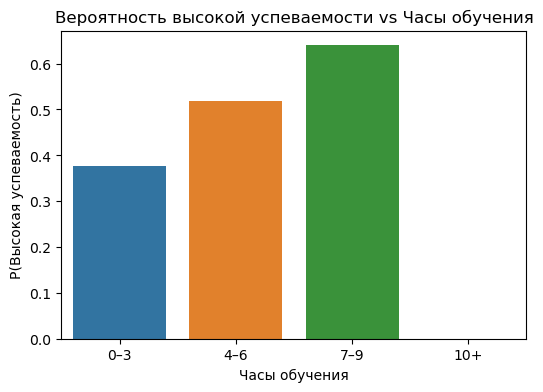

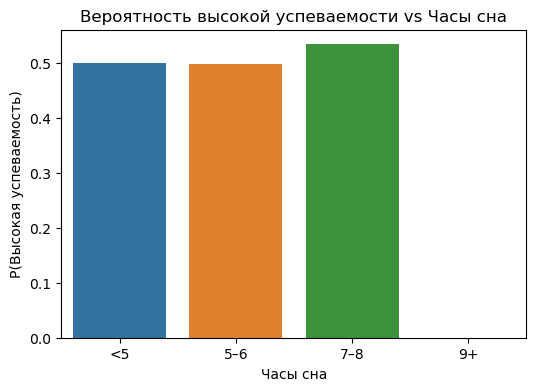

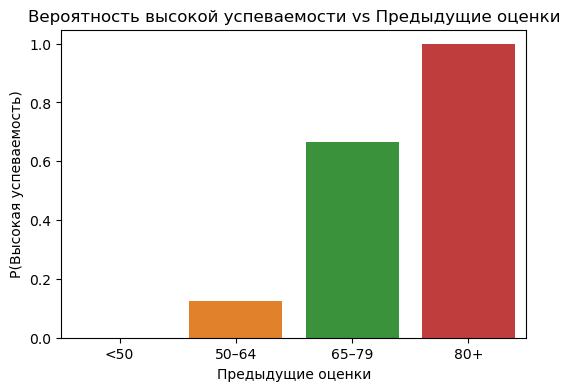

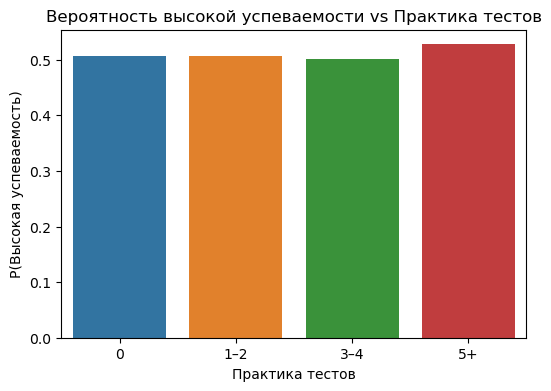

In [9]:
features = [
    "Часы обучения",
    "Часы сна",
    "Предыдущие оценки",
    "Практика тестов",
]

for col in features:
    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=df_cat,
        x=col,
        y="High Performance",
        estimator=np.mean,
        errorbar=None,
    )
    plt.title(f"Вероятность высокой успеваемости vs {col}")
    plt.ylabel("P(Высокая успеваемость)")
    plt.show()


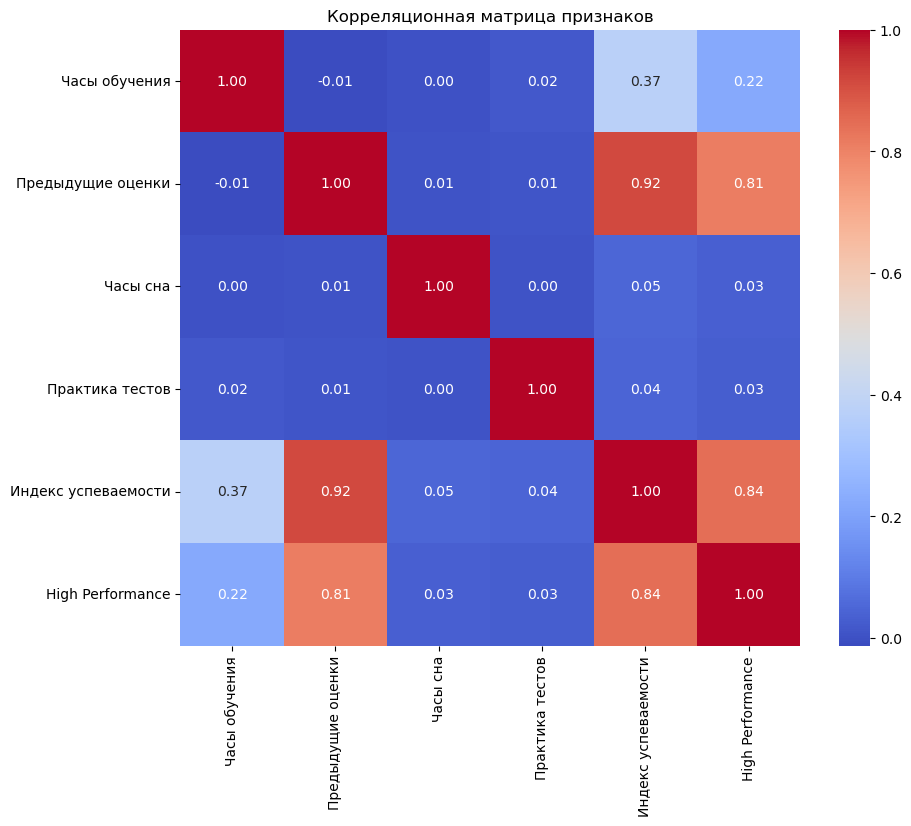

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица признаков")
plt.show()


In [11]:
display(
    Markdown(
        """
### Выводы:

- Наибольшее влияние оказывает **предыдущая академическая успеваемость**  
- **Часы обучения** и **практика тестов** положительно коррелируют с результатом  
- Недостаток сна снижает вероятность высокой успеваемости  
- Внеучебная активность оказывает умеренное влияние
"""
    )
)



### Выводы:

- Наибольшее влияние оказывает **предыдущая академическая успеваемость**  
- **Часы обучения** и **практика тестов** положительно коррелируют с результатом  
- Недостаток сна снижает вероятность высокой успеваемости  
- Внеучебная активность оказывает умеренное влияние
